# SIFT尺度不变特征变换

### 目标

在这一章当中，
- 我们将学习SIFT算法的概念 
- 我们将学习找到SIFT关键点和描述算符。

### 理论

在前两章中，我们看到了一些像Harris这样的拐角检测器。它们是旋转不变的，这意味着即使图像旋转了，我们也可以找到相同的角。很明显，因为转角在旋转的图像中也仍然是转角。但是缩放呢？如果缩放图像，则拐角可能不是角。例如，检查下面的简单图像。在同一窗口中放大小窗口中小图像中的拐角时，该角是平坦的。因此，Harris拐角不是尺度不变的。

![](data/sift_scale_invariant.jpg)

因此，在2004年，不列颠哥伦比亚大学的**D.Lowe**在他的论文《**尺度不变关键点中的独特图像特征**》中提出了一种新算法，即尺度不变特征变换(SIFT)，该算法提取关键点并计算其描述算符。 *（该论文易于理解，被认为是学习SIFT的最佳材料。因此，本文只是该论文的简短摘要）*。 SIFT算法主要包括四个步骤。 我们将一一看到它们。

SIFT算法主要包括四个步骤。我们将一一看到它们。
 
#### 1. 尺度空间极值检测

从上图可以明显看出，我们不能使用相同的窗口来检测具有不同比例的关键点。即便小拐角可以。但是要检测更大的拐角，我们将需要更大的窗口。为此，使用了比例空间滤波。在其中，找到具有各种$σ$值的图像的高斯拉普拉斯算子。LoG用作斑点检测器，可检测由于$σ$的变化而导致的各种大小的斑点。简而言之，$σ$用作缩放参数。例如，在上图中，低$σ$的高斯核对于较小的拐角给出较高的值，而高$σ$的高斯核对于较大的拐角而言非常合适。因此，我们可以找到整个尺度和空间上的局部最大值，这给了我们$(x,y,σ)$值的列表，这意味着在$(x,y)$在$σ$尺度上有一个潜在的关键点。

但是这种LoG代价昂贵，因此SIFT算法使用的是高斯差值，它是LoG的近似值。高斯差是作为具有两个不同$σ$的图像的高斯模糊差而获得的，设为$σ$和$kσ$。此过程是针对高斯金字塔中图像的不同八度完成的。如下图所示：

![](data/sift_dog.jpg)

一旦找到该DoG，便会在图像上搜索比例和空间上的局部极值。例如，将图像中的一个像素与其8个相邻像素以及下一个比例的9个像素和前一个比例的9个像素进行比较。如果是局部极值，则可能是关键点。从根本上说，关键点是最好的代表。如下图所示：

![](data/sift_local_extrema.jpg)

对于不同的参数，本文给出了一些经验数据，可以概括为：octaves=4，缩放尺度=5，初始$σ=1.6$，$k=\sqrt{2}$等作为最佳值。

#### 2. 关键点定位

一旦找到潜在的关键点位置，就必须对其进行优化以获取更准确的结果。他们使用了标度空间的泰勒级数展开来获得更精确的极值位置，如果该极值处的强度小于阈值（根据论文为0.03），则将其拒绝。在OpenCV DoG中，此阈值称为**ContrastThreshold**，它对边缘的响应较高，因此也需要删除边缘。

为此，使用类似于哈里斯拐角检测器的概念。他们使用2x2的Hessian矩阵(H)计算主曲率。从哈里斯拐角检测器我们知道，对于边缘，一个特征值大于另一个特征值。因此，这里他们使用了一个简单的函数。

如果该比率大于一个阈值（在OpenCV中称为**edgeThreshold**），则该关键点将被丢弃。论文上写的值为10。

因此，它消除了任何低对比度的关键点和边缘关键点，剩下的就是很可能的目标点。

#### 3. 方向分配

现在，将方向分配给每个关键点，以实现图像旋转的不变性。根据比例在关键点位置附近采取邻域，并在该区域中计算梯度大小和方向。创建了一个具有36个覆盖360度的bin的方向直方图（通过梯度幅度和$σ$等于关键点比例的1.5的高斯加权圆窗加权）。提取直方图中的最高峰，并且将其超过80％的任何峰也视为计算方向。它创建的位置和比例相同但方向不同的关键点。它有助于匹配的稳定性。

#### 4. 关键点描述

现在创建了关键点描述符。在关键点周围采用了16x16的邻域。它分为16个4x4大小的子块。对于每个子块，创建8 bin方向直方图。因此共有128个bin值可用。它被表示为形成关键点描述符的向量。除此之外，还采取了几种措施来实现针对照明变化，旋转等的鲁棒性。

#### 5. 关键点匹配

通过识别两个图像的最近邻，可以匹配两个图像之间的关键点。但是在某些情况下，第二个最接近的匹配可能非常接近第一个。它可能是由于噪音或其他原因而发生的。在那种情况下，采用最接近距离与第二最接近距离之比。如果大于0.8，将被拒绝。根据论文，它可以消除大约90％的错误匹配，而仅丢弃5％的正确匹配。
因此，这是SIFT算法的总结。有关更多详细信息和理解，强烈建议阅读原始论文。记住一件事，该算法已申请专利。所以这个算法包含在opencv contrib repo中 

### OpenCV中的SIFT

现在，让我们来看一下OpenCV中可用的SIFT功能。让我们从关键点检测开始并进行绘制。首先，我们必须构造一个SIFT对象。我们可以将不同的参数传递给它，这些参数是可选的，它们在docs中已得到很好的解释。

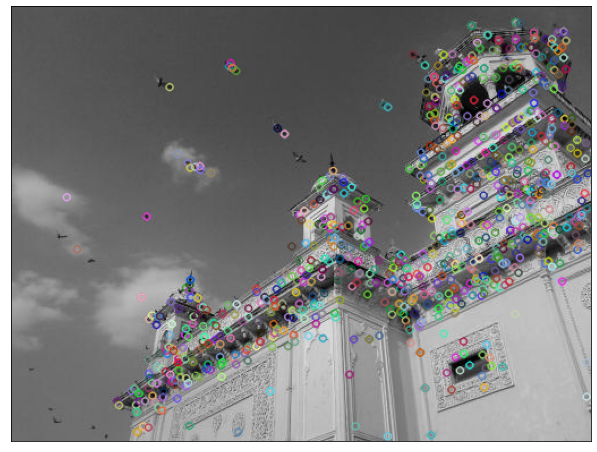

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img = cv.imread('data/home.jpg')

gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)

sift = cv.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)

img=cv.drawKeypoints(gray,kp,img)

cv.imwrite('output/sift_keypoints1.jpg',img)

plt.figure(figsize=(12,8))
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.show()

**sift.detect**()函数在图像中找到关键点。如果只想搜索图像的一部分，则可以通过掩码。每个关键点是一个特殊的结构，具有许多属性，例如其(x，y)坐标，有意义的邻域的大小，指定其方向的角度，指定关键点强度的响应等。

OpenCV还提供**cv.drawKeyPoints**()函数，该函数在关键点的位置绘制小圆圈。
如果将标志**cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS**传递给它，它将绘制一个具有关键点大小的圆，甚至会显示其方向。
请参见以下示例。

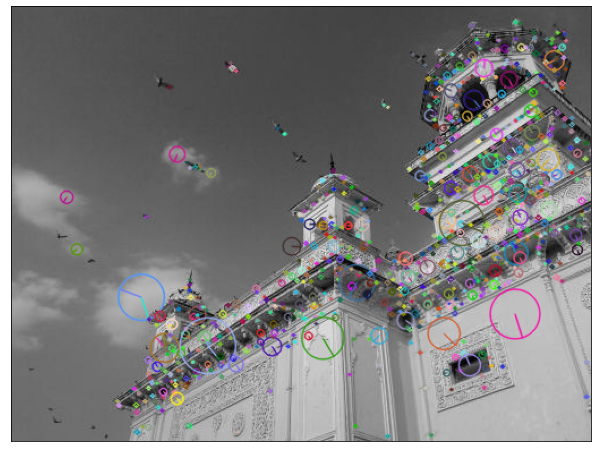

In [2]:
img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imwrite('output/sift_keypoints2.jpg',img)

plt.figure(figsize=(12,8))
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.show()

现在要计算描述符，OpenCV提供了两种方法。
1. 由于已经找到关键点，因此可以调用**sift.compute**()，该函数根据我们找到的关键点来计算描述符。例如：`kp，des = sift.compute(gray，kp)`
2. 如果找不到关键点，则可以使用**sift.detectAndCompute**()函数在单步骤中直接找到关键点和描述符。

我们将看到第二种方法：

In [3]:
sift = cv.xfeatures2d.SIFT_create() 
kp, des = sift.detectAndCompute(gray,None)

这里的kp将是一个关键点列表，而des是一个形状为$Number_of_Keypoints×128$的数字数组。 

这样我们得到了关键点，描述符等。现在我们想看看如何在不同图像中匹配关键点。我们将在接下来的章节中学习。

### 附加资源

### 练习